Can experience and age predict hours played?

In [82]:
library(tidyverse)
library(repr)
library(tidymodels)
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [83]:
set.seed(2020)

In [84]:
players <- read_csv('players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [85]:
players_tidy <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    # filter(6000 > played_minutes) |>
    select(experience, Age, played_minutes)
players_tidy

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
5,9,1818
4,17,228
4,17,0
2,21,42
3,21,6
2,17,0
3,19,0
2,21,0
2,17,6


In [86]:
players_with_zero <- players_tidy |>
    filter(played_minutes == 0) |>
    count()
players_with_zero

n
<int>
85


In [87]:
players_over100 <- players_tidy |>
    filter(played_minutes > 6000) |>
    count()
players_over100

n
<int>
4


In [88]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_minutes = mean(played_minutes))
experience_playtime_means

experience,mean_player_minutes
<dbl>,<dbl>
1,74.91429
2,361.04762
3,1123.54286
4,38.87500
5,167.07692


In [89]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<dbl>,<dbl>
1,21.65714
2,20.25397
3,20.60000
4,20.95833
5,16.92308


In [90]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_minutes)
players_train <- training(players_split)
players_test <- testing(players_split)

In [91]:
players_recipe <- recipe(played_minutes ~ experience + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_minutes)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [92]:
gridvals <- tibble(neighbors = seq(from = 1, to = 109, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,991.7460,5,338.2189,Preprocessor1_Model001
2,rmse,standard,824.7190,5,275.7613,Preprocessor1_Model002
3,rmse,standard,779.4954,5,279.9608,Preprocessor1_Model003
4,rmse,standard,746.6644,5,275.8866,Preprocessor1_Model004
5,rmse,standard,741.0380,5,277.9024,Preprocessor1_Model005
6,rmse,standard,756.9317,5,269.6081,Preprocessor1_Model006
7,rmse,standard,733.4913,5,274.7330,Preprocessor1_Model007
8,rmse,standard,731.5538,5,273.8479,Preprocessor1_Model008
9,rmse,standard,729.0941,5,273.6137,Preprocessor1_Model009


In [93]:
players_min <- players_results |>
    filter(mean == min(mean))
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
62,rmse,standard,710.3172,5,264.3127,Preprocessor1_Model062


In [94]:
players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 62) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3056.716


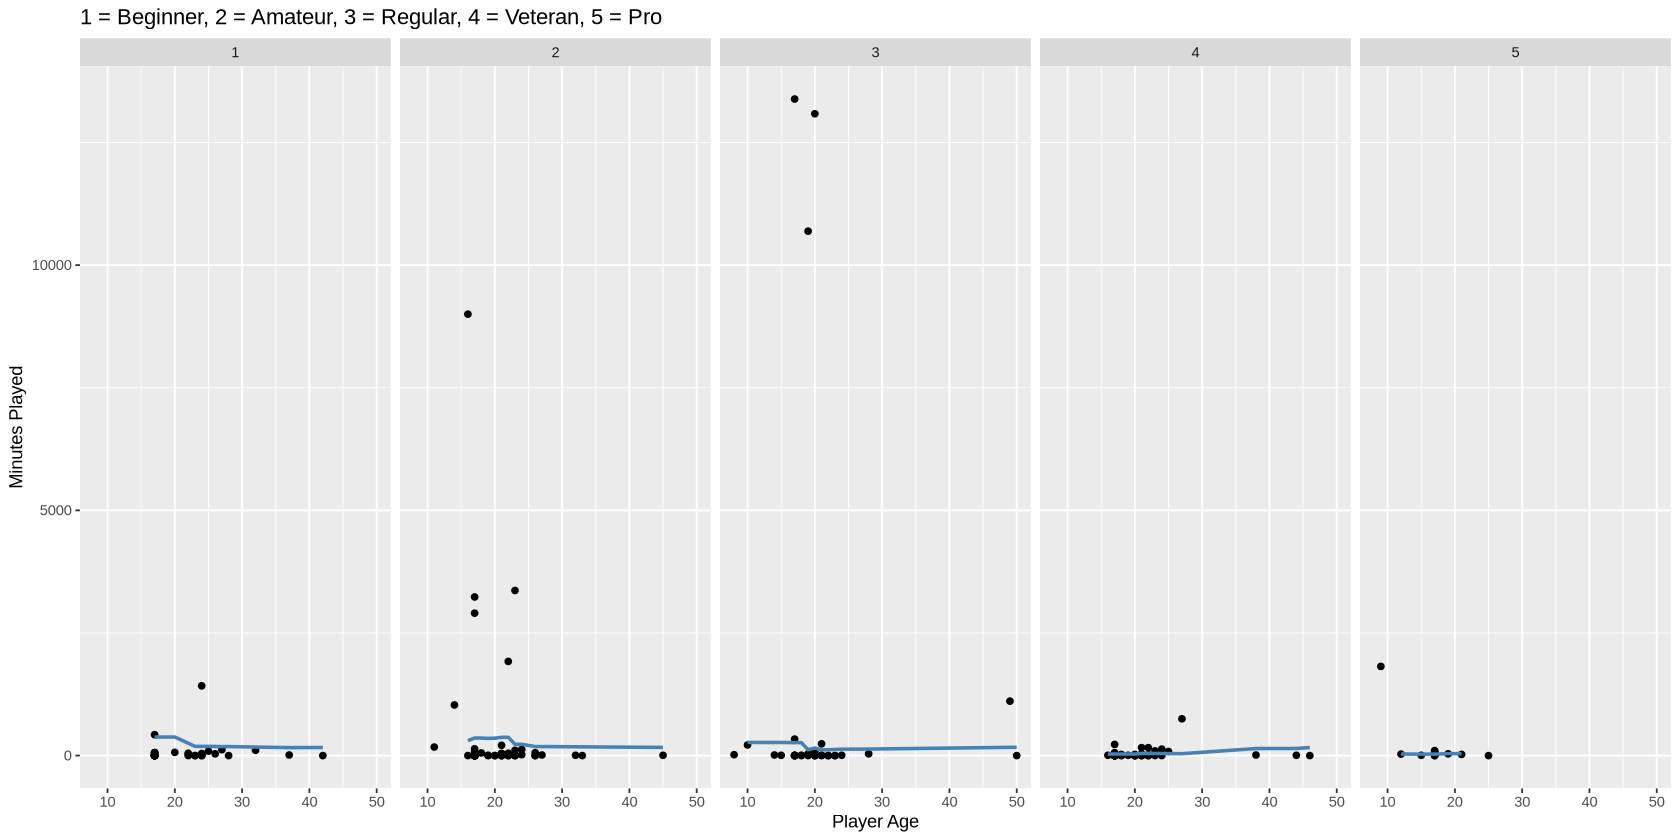

In [95]:
players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot + facet_wrap(~experience, ncol = 5)

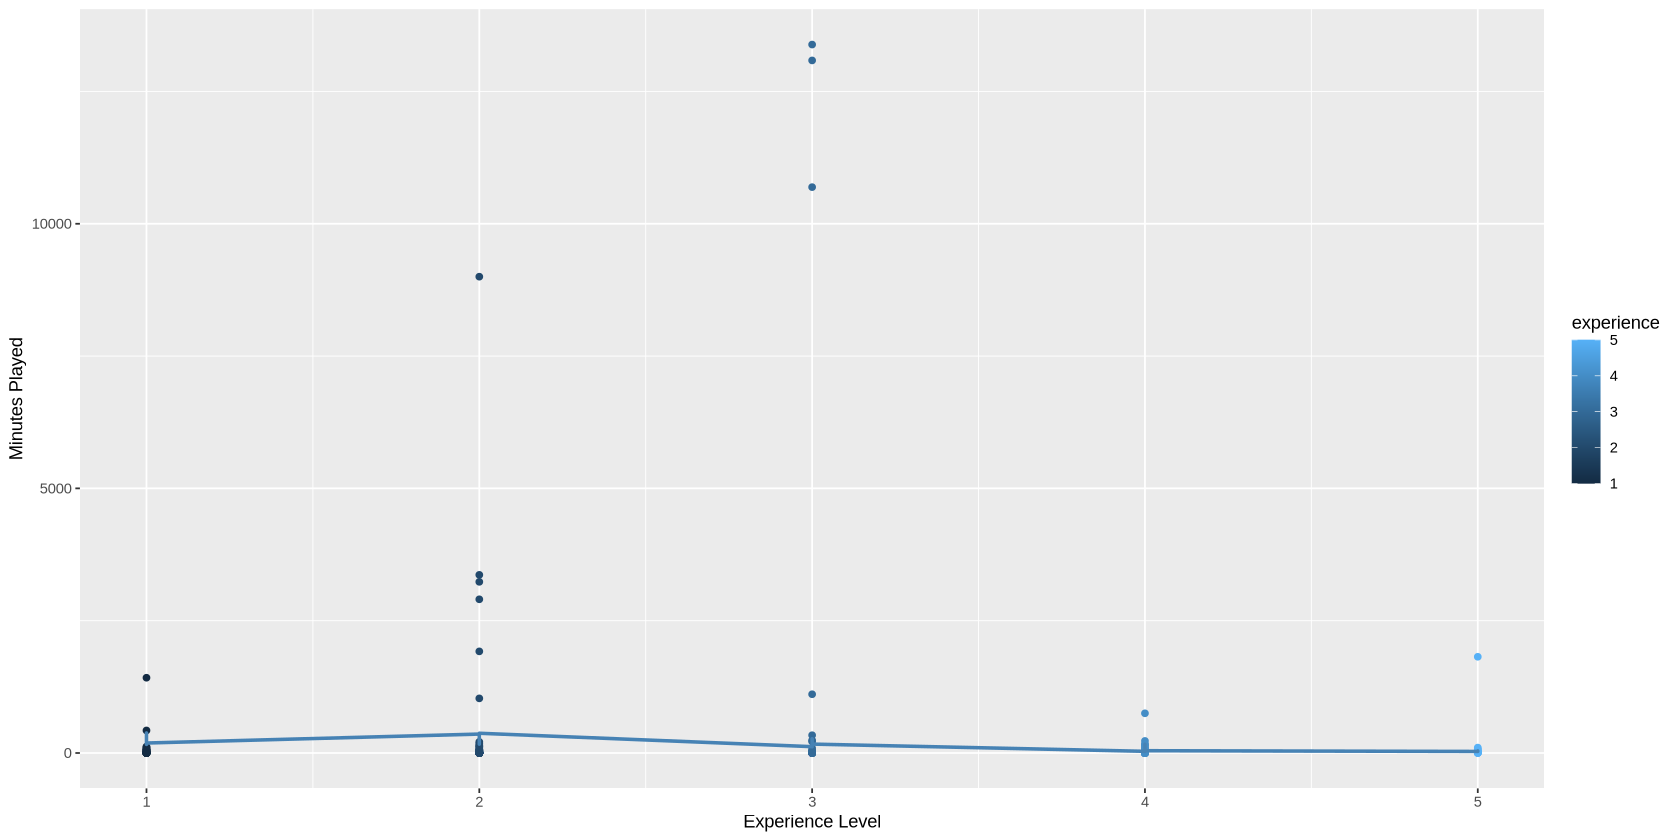

In [96]:
players_experience_plot <- ggplot(players_tidy, aes(x = experience, y = played_minutes, color = experience)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = experience, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Experience Level") +
  ylab("Minutes Played")

players_experience_plot

In [97]:
players_preds |>
    # group_by(Age) |>
    # summarize(mean_ph = mean(played_hours)) |>
    arrange(Age)

.pred,experience,Age,played_minutes
<dbl>,<dbl>,<dbl>,<dbl>
267.87097,3,10,216
31.64516,5,12,30
267.38710,3,14,12
267.38710,3,15,6
30.00000,4,16,6
303.48387,2,16,0
303.48387,2,16,9000
31.64516,4,17,0
357.58065,2,17,0


In [98]:
players_preds |> filter(Age == 17, experience == 5)

.pred,experience,Age,played_minutes
<dbl>,<dbl>,<dbl>,<dbl>
29.51613,5,17,0
29.51613,5,17,0
29.51613,5,17,12
29.51613,5,17,12
29.51613,5,17,60
29.51613,5,17,72
29.51613,5,17,102


In [99]:
new_player <- tibble(experience = 5, Age = 10, played_hours = 0.0)
new_predictions <- players_fit |>
    predict(new_player) |>
    bind_cols(new_player)
new_predictions

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
31.64516,5,10,0


In [100]:
new_player2 <- tibble(experience = 3, Age = 20, played_hours = 0.0)
new_prediction2 <- players_fit |>
    predict(new_player2) |>
    bind_cols(new_player2)
new_prediction2

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
154.7419,3,20,0


In [102]:
players_no_outliers <- players |>
    na.omit() |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),) |>
    mutate(played_minutes = played_hours * 60) |>
    filter(6000 > played_minutes) |>
    select(experience, Age, played_minutes)
players_no_outliers

experience,Age,played_minutes
<dbl>,<dbl>,<dbl>
5,9,1818
4,17,228
4,17,0
2,21,42
3,21,6
2,17,0
3,19,0
2,21,0
2,17,6


In [105]:
players_split2 <- initial_split(players_no_outliers, prop = 0.75, strata = played_minutes)
players_train2 <- training(players_split2)
players_test2 <- testing(players_split2)

players_recipe2 <- recipe(played_minutes ~ experience + Age, data = players_train2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold2 = vfold_cv(players_train2, v = 5, strata = played_minutes)

players_workflow2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec_tune2)

gridvals2 <- tibble(neighbors = seq(from = 1, to = 107, by = 1))

players_results2 <- players_workflow2 |>
  tune_grid(resamples = players_vfold2, grid = gridvals2) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_results2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,431.3350,5,90.12424,Preprocessor1_Model001
2,rmse,standard,440.6072,5,88.58539,Preprocessor1_Model002
3,rmse,standard,435.0124,5,98.11674,Preprocessor1_Model003
4,rmse,standard,424.8489,5,99.74869,Preprocessor1_Model004
5,rmse,standard,420.1542,5,101.85539,Preprocessor1_Model005
6,rmse,standard,418.8755,5,100.76494,Preprocessor1_Model006
7,rmse,standard,411.2590,5,103.76262,Preprocessor1_Model007
8,rmse,standard,422.3333,5,96.44255,Preprocessor1_Model008
9,rmse,standard,406.1916,5,106.70090,Preprocessor1_Model009


In [107]:
players_min2 <- players_results2 |>
    filter(mean == min(mean))
players_min2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
56,rmse,standard,390.296,5,102.7211,Preprocessor1_Model056


In [108]:
players_spec2 <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 56) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(players_spec2) |>
    fit(data = players_train2)

players_summary2 <- players_fit2 |>
  predict(players_test2) |>
  bind_cols(players_test2) |>
  metrics(truth = played_minutes, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,508.6583


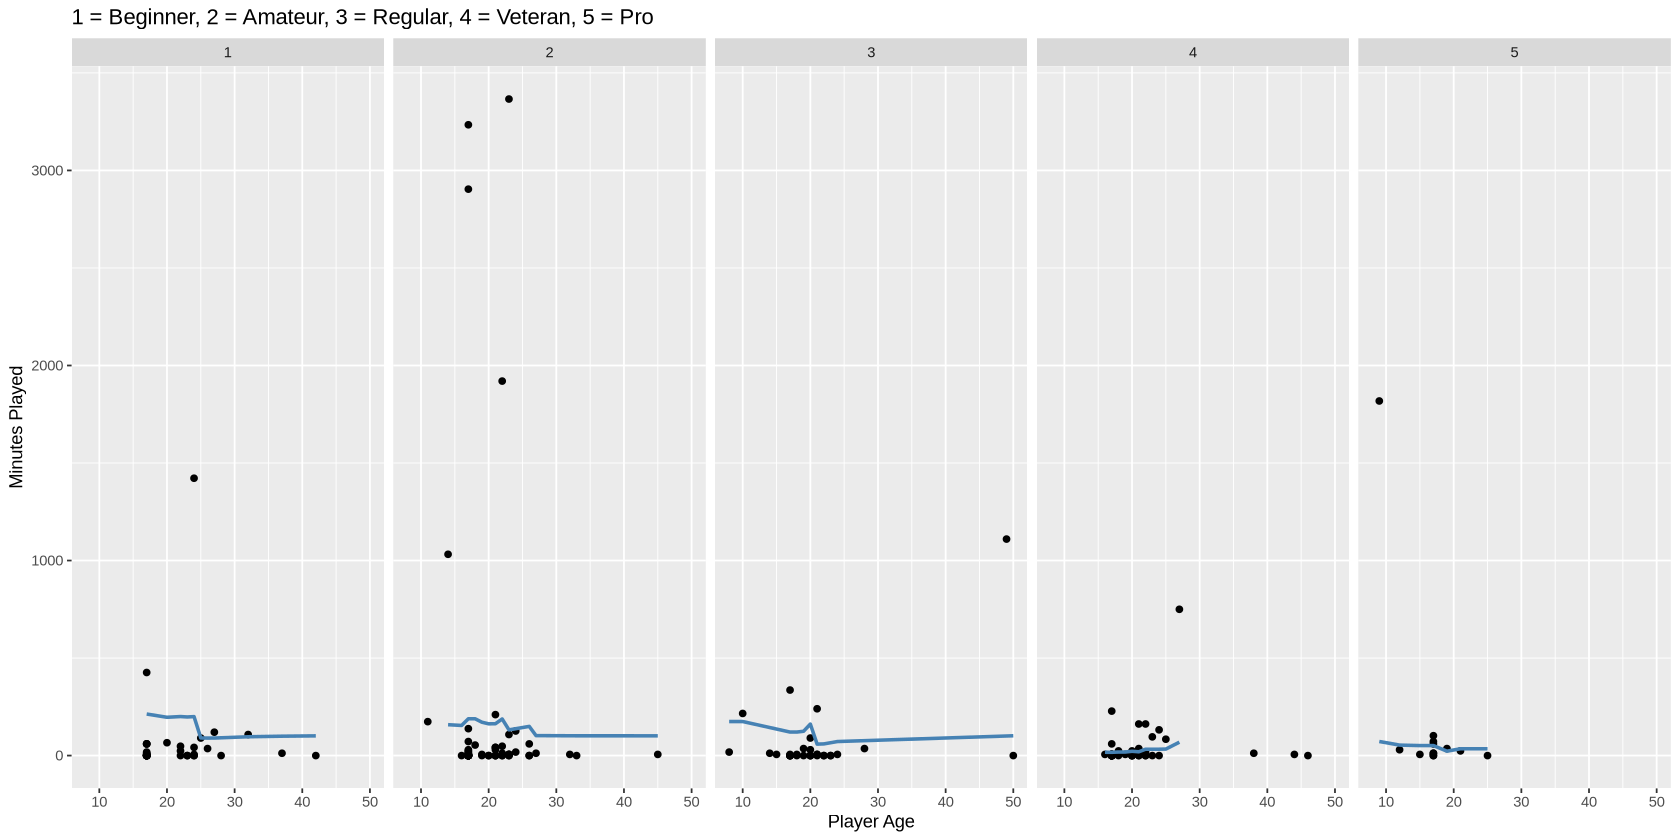

In [109]:
players_preds2 <- predict(players_fit2, players_train2) |>
        bind_cols(players_train2)

options(repr.plot.width = 14, repr.plot.height = 7)

players_plot2 <- ggplot(players_no_outliers, aes(x = Age, y = played_minutes)) +
  geom_point() +
  geom_line(data = players_preds2,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Minutes Played") +
    ggtitle('1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro')

players_plot2 + facet_wrap(~experience, ncol = 5)

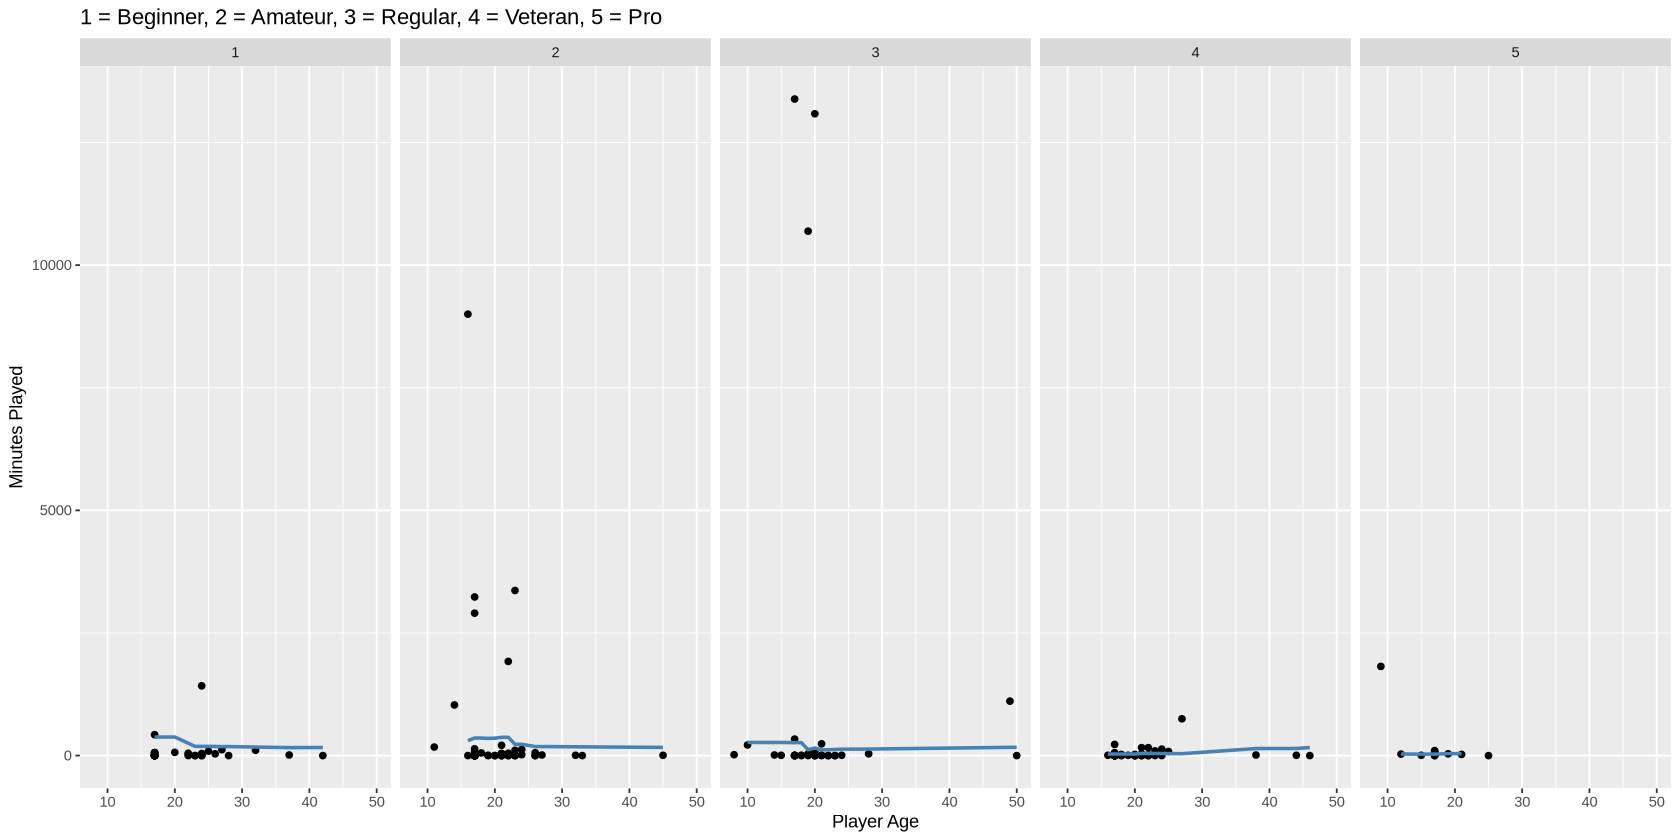

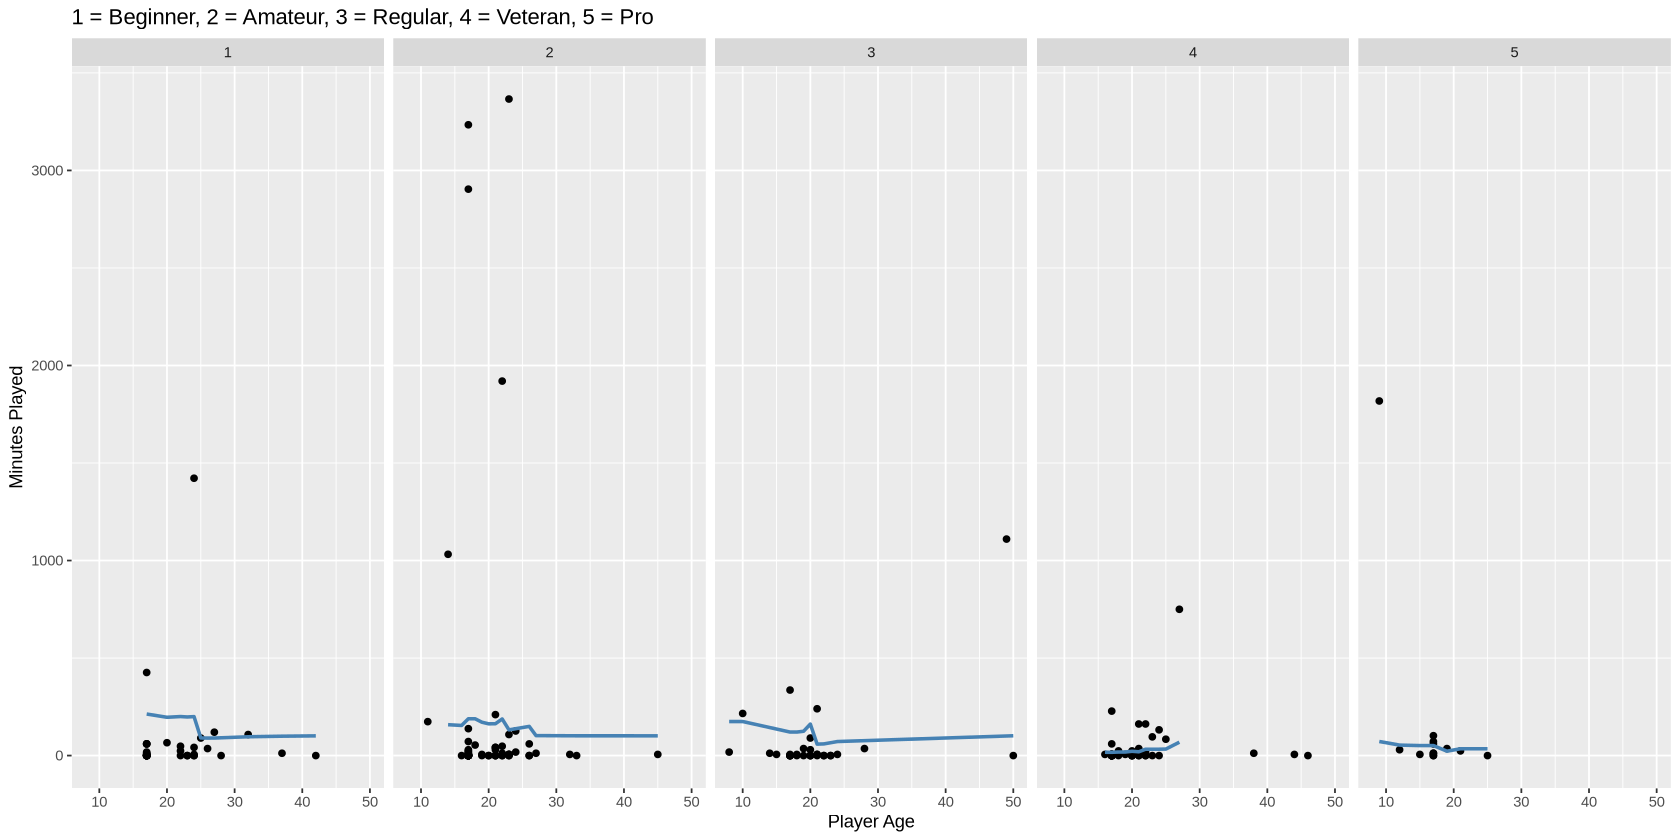

In [124]:
players_plot + facet_wrap(~experience, ncol = 5)
players_plot2 + facet_wrap(~experience, ncol = 5)

In [126]:
new_player2 <- tibble(experience = 5, Age = 10, played_hours = 0.0)
new_prediction2 <- players_fit |>
    predict(new_player2) |>
    bind_cols(new_player2)

new_prediction_no_outliers <- players_fit2 |>
    predict(new_player2) |>
    bind_cols(new_player2)


new_prediction2
new_prediction_no_outliers

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
31.64516,5,10,0


.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
53.78571,5,10,0


In [123]:
new_prediction_no_outliers <- players_fit2 |>
    predict(new_player2) |>
    bind_cols(new_player2)
new_prediction_no_outliers

.pred,experience,Age,played_hours
<dbl>,<dbl>,<dbl>,<dbl>
36,5,20,0


In [15]:
regulars <- players_tidy |>
    filter(experience == 'Regular')

regulars_split <- initial_split(regulars, prop = 0.75, strata = played_hours)
regulars_train <- training(regulars_split)
regulars_test <- testing(regulars_split)

regulars_recipe <- recipe(played_hours ~ Age, data = regulars_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

regulars_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

regulars_vfold = vfold_cv(regulars_train, v = 5, strata = played_hours)

regulars_workflow <- workflow() |>
    add_recipe(regulars_recipe) |>
    add_model(regulars_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

regulars_results <- regulars_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
regulars_min <- regulars_results |>
    filter(mean == min(mean))
regulars_min

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


ERROR: [1m[33mError[39m in `tibble::tibble()`:[22m
[1m[22m[33m![39m Tibble columns must have compatible sizes.
[36m•[39m Size 2: Existing data.
[36m•[39m Size 0: Column `strata`.
[36mℹ[39m Only values of size one are recycled.


In [16]:
regulars

experience,Age,played_hours
<dbl>,<dbl>,<dbl>


In [ ]:
players_real <- players_tidy |>
    filter(played_hours != 0)

players_real_split <- initial_split(players_real, prop = 0.75, strata = played_hours)
players_real_train <- training(players_real_split)
players_real_test <- testing(players_real_split)

players_real_recipe <- recipe(played_hours ~ Age, data = players_real_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_real_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_vfold = vfold_cv(players_real_train, v = 5, strata = played_hours)

players_real_workflow <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 32, by = 1))

players_real_results <- players_real_workflow |>
  tune_grid(resamples = players_real_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_real_min <- players_real_results |>
    filter(mean == min(mean))
players_real_min

In [ ]:
players_real_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 24) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_fit <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec) |>
    fit(data = players_real_train)

players_real_summary <- players_real_fit |>
  predict(players_real_test) |>
  bind_cols(players_real_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_real_summary

In [ ]:
players_real_preds <- predict(players_real_fit, players_real_train) |>
        bind_cols(players_real_train)

players_real_plot <- ggplot(players_real, aes(x = Age, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_real_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played")

players_real_plot

In [ ]:
players_real_preds |>
    arrange(Age)